In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 10. 케라스를 사용한 인공 신경망 소개

## 10.1 생물학적 뉴런에서 인공 뉴런까지

### 10.1.1 생물학적 뉴런

- 구성 요소 : 수상돌기, 축삭돌기(축삭끝가지 -- 시냅스 말단과 연결)
- 활동전위/신호라 불리는 전기자극은 축삭돌기를 따라 이동해 시냅스가 신경전달물질을 발생하게 함.

### 10.1.2 뉴런을 사용한 논리연산

### 10.1.3 퍼셉트론

- 가장 간단한 인공 신경망 구조
- 층이 하나인 TLU(입력 가중치합을 계산하고, 계단함수를 적용하는 인공뉴런)로 구성됨.
- 계단함수로 헤비사이드 계단함수를 사용.(unit step function)과 동일

- 완전 연결 층/밀집 층 : 한 층의 모든 뉴런이 이전 층의 모든 뉴런과 연결되어있을 때
- 입력값은 입력 뉴런으로 이루어진 입력층에 주입되고, 여기에 편향 특성이 더해져 출력층으로 내보내짐.


- $ h_{w,b}(X) = \phi(XW + b) $
    - X는 입력 특성의 행렬
    - 가중치 행렬 W의 행은 입력 뉴런, 열은 출력층의 인공뉴런
    - 편향 b는 편향 뉴런과 인공 뉴런 사이의 모든 연결 가중치를 포함
    - $\phi$는 활성화함수

- 퍼셉트론 알고리즘은 헤브의 규칙에서 영향 받음
    - 서로 활성화되는 세포가 서로 연결된다 == 두 뉴런이 동시에 활성화될 때마다 이들 사이의 연결 가중치가 증가한다.
    

- 퍼셉트론의 학습 규칙은 오차가 감소되도록 연결을 강화시킨다.
    - 각 샘플에 대해 예측이 만들어지면, 잘못된 예측을 하는 뉴런에 대해 올바른 예측을 만들 수 있게 입력에 연결된 가중치를 강화시킨다.
    - 가중치 업데이트 규칙 : $ w_{i,j}^{(next step)} = w_{i,j} + \mu(y_j - \hat{y_j})x_i$

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

C:\Users\YOUTH_~1\AppData\Local\Temp/ipykernel_5444/3535985977.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int)


In [3]:
y_pred

array([1])

### 10.1.4 다층 퍼셉트론과 역전파

- 입력층 1개, 은닉층(여러개 가능), 출력층으로 구성
- 은닉층을 여러 개 쌓아 올린 인공 신경망을 DNN(심층 신경망)이라고 함.

##### 역전파 알고리즘
1. 각 훈련 샘플에 대해 역전파 알고리즘이 먼저 예측을 만들고 오차를 측정(정방향)
2. 역방향으로 각 층을 거꾸러 거치면서 각 연결이 오차에 기여한 정도를 chain rule을 통해서 측정(역방향)
3. 이 오차가 감소하도록 가중치를 조정(경사하강법)

- 계단함수를 시그모이드 함수로 변경(tanh나 ReLU도 활성화함수로 널리 쓰인다)

### 10.1.5 회귀를 위한 다층 퍼셉트론
- 입력 뉴런 수 : 특성마다 하나
- 은닉층 수 : 다양(일반적으로 5 이하)
- 은닉층 뉴런 수 : 다양(일반적으로 10 ~ 100)
- 출력 뉴런 수 : 예측 차원마다 하나
- 은닉층 활성화함수 : ReLU
- 출력층 활성화 함수 : 없음/ReLU, 시그모이드, tanh등등
- 손실함수 : MSE / 이상치 있으면 MAE/Huber

### 10.1.6 분류를 위한 다층 퍼셉트론
 - 입력층과 은닉층 수 : 회귀와 동일
 - 출력 뉴런 수 : 이진(1개), 다중레이블 분류(레이블마다 1개), 다중분류(클래스마다 1개)
 - 출력층 활성화 함수 : 시그모이드 함수(이진, 다중 레이블), 소프트맥스 함수(다중분류)
 - 손실 함수 : 크로스 엔트로피
 
다중 레이블 분류 : 하나의 입력값이 여러 개의 클래스에 대응되는 경우

## 10.2 케라스로 다층 퍼셉트론 구현하기

### 10.2.1 텐서플로2 설치

In [4]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.9.1'

In [5]:
keras.__version__

'2.9.0'

### 10.2.2 시퀀셜 API를 사용해 이미지 분류기 만들기

케라스로 데이터셋 적재

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [7]:
X_train_full.shape

(60000, 28, 28)

In [8]:
X_train_full.dtype

dtype('uint8')

In [9]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.
# 각 픽셀을 255로 나누어 0 ~ 1 사이 범위로 스케일 조정

In [10]:
np.max(X_test[0])

1.0

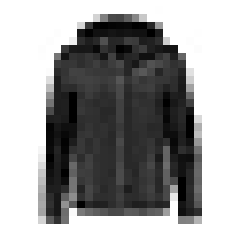

In [11]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [12]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [14]:
class_names[y_train[0]]

'Coat'

In [15]:
X_test.shape

(10000, 28, 28)

그림 저장: fashion_mnist_plot


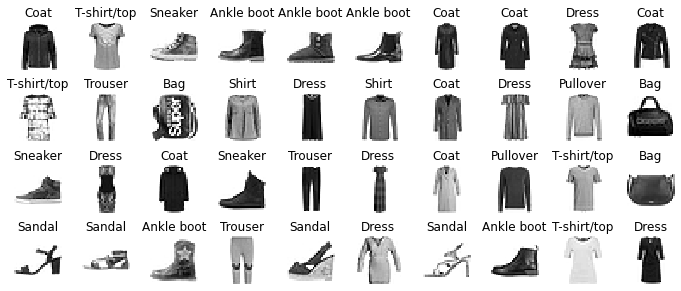

In [16]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

시퀀셜 API를 사용해 모델 만들기

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28])) # 입력 데이터 [28,28]를 1D로 변경
model.add(keras.layers.Dense(300, activation = 'relu')) # 뉴런 300개 은닉층
model.add(keras.layers.Dense(100, activation = 'relu')) # 뉴런 100개 은닉층
model.add(keras.layers.Dense(10, activation = 'softmax')) # 뉴런 10개의 출력층, 다중분류이므로 softmax함수 사용

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [20]:
model.layers

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


23500 = 784 * 300 +300

In [22]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [23]:
model.get_layer('dense') is hidden1

True

In [24]:
weights, biases = hidden1.get_weights()

In [25]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

모델 컴파일

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"]) # 손실함수와 옵티마이저 지정, 훈련, 평가시 사용할 지표도 지정

# 레이블이 정수 하나로 이루어져 있고, 배타적이므로 sparse_categorical_crossentropy쓰고, 원핫벡터라면 categorical_crossentropy씀.
# 이진분류나 다중레이블이진분류이면 binary_crossentropy사용

# sgd : 기본 확률적 경사하강법(sgd) 사용해서 모델 훈련한다는 의미(역전파 알고리즘 수행). 기본 lr은 0.01

모델 훈련과 평가

In [27]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid)) # validation_split=0.1로 하면 검증에 사용할 훈련 세트의 비율을 10%로 지정.

Epoch 1/30
1719/1719 [==============================] - 5s 2ms/step - loss: 0.7235 - accuracy: 0.7645 - val_loss: 0.5205 - val_accuracy: 0.8224
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4840 - accuracy: 0.8320 - val_loss: 0.4343 - val_accuracy: 0.8534
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4387 - accuracy: 0.8457 - val_loss: 0.5317 - val_accuracy: 0.7982
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4122 - accuracy: 0.8565 - val_loss: 0.3916 - val_accuracy: 0.8646
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3938 - accuracy: 0.8617 - val_loss: 0.3743 - val_accuracy: 0.8684
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3753 - accuracy: 0.8677 - val_loss: 0.3710 - val_accuracy: 0.8716
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3633 - accuracy: 0.8714 - val_loss: 0.3621 - val_accuracy:

- 클래스 불균형이 있을때는 fit() 호출할 때 class_weight를 지정하여 적은 클래스에는 높은 가중치를, 많은 클래스에는 낮은 가중치를 부여하는 것이 좋다.
- 샘플 별로 가중치를 부여하고 싶으면 sample_weight를 지정할 수 있다.

History 객체에는 history.params(훈련 파라미터), history.epoch(수행된 에포크 리스트)가 포함되어 있다.  
history.history는 에포크 끝날 때 마다 훈련세트와 검증 세트에 대한 손실과 지표에 대한 정보를 담고 있다.

In [28]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [29]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

그림 저장: keras_learning_curves_plot


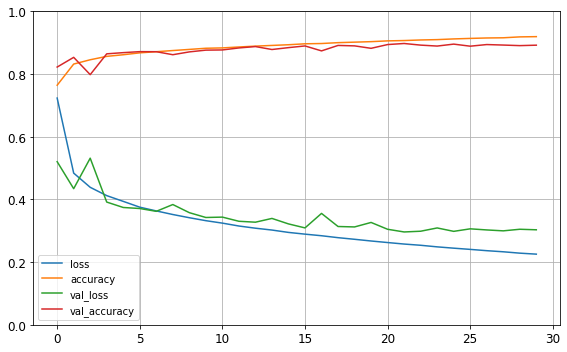

In [31]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

훈련 초기에 검증 세트의 성능이 더 높은 것으로 보이나, 사실 <u>검증 손실은 에포크가 끝난 후에 계산되고, 훈련 손실은 에포크가 진행되는 동안 계산되기 때문에, 훈련 곡선은 에포크의 절반만큼 왼쪽으로 이동해야 한다.</u>  이렇게 보면 훈련 초기에 훈련 곡선과 검증 곡선이 거의 일치한다.

일반적으로 충분히 오래 훈련하면 훈련 세트의 성능이 더 높게 나타나며, 검증 손실이 계속 감소한다면 수렴하지 않았으므로 훈련이 더 진행되어야 한다.

모델 성능이 만족스럽지 않다면 하이퍼파라미터를 튜닝해야 한다.
1. 학습률 튜닝
2. 다른 옵티마이저 테스트
3. 층 개수, 층의 뉴런 개수, 활성화함수 튜닝
4. 배치 크기 변화

모델 성능에 만족한다면 테스트 세트로 모델 평가하여 일반화 오차를 추정해야 한다.

In [32]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3352 - accuracy: 0.8831


[0.3351794481277466, 0.8830999732017517]

모델을 사용하여 예측 만들기

In [33]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 72ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [34]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 15ms/step


array([9, 2, 1], dtype=int64)

In [35]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [36]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

그림 저장: fashion_mnist_images_plot


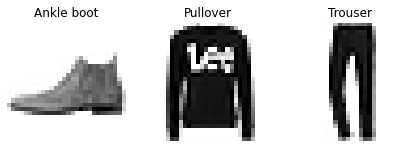

In [37]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

### 10.2.3 시퀀셜 API를 사용하여 회귀용 다층 퍼셉트론 만들기

In [38]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

분류와의 차이점은 출력층이 활성화 함수가 없는 하나의 뉴런을 가진다는 것과 손실함수로 MSE를 사용한다는 것이다.  
  이 데이터셋에서는 과대적합을 막는 용도로 뉴런 수가 적은 은닉층 하나만 사용하겠다.

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

In [40]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),# 은닉층 하나
    keras.layers.Dense(1) # 출력층
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))# lr 조정
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4875 - val_loss: 0.4656

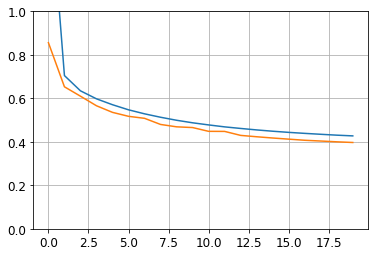

In [41]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [42]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022794 ]], dtype=float32)

### 10.2.4 함수형 API를 사용해 복잡한 모델 만들기

입력의 일부 또는 전체가 출력층에 바로 연결된 와이드 & 딥 신경망을 사용할 경우, 복잡한 패턴과 간단한 규칙을 모두 학습할 수 있다.  
  기본 MLP의 경우 데이터가 모든 층을 통과하기 때문에 간단한 패턴의 경우 층을 통과하면서 왜곡될 수 있다.

이처럼 복잡한 모델을 만들 경우 시퀀셜 API보다 함수형 API를 사용하여 신경망을 구성한다.

#### 와이드 & 딥 신경망을 함수형 API로 구현하기

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

In [44]:
input_ = keras.layers.Input(shape=X_train.shape[1:]) # 입력층, input 객체 형성
hidden1 = keras.layers.Dense(30, activation="relu")(input_) # 뉴런 30개 은닉층1
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)# 뉴런 30개 은닉층2
concat = keras.layers.concatenate([input_, hidden2]) # 은닉층 2의 결과와 입력층을 연결
output = keras.layers.Dense(1)(concat) # 출력층_ 뉴런 1개, 활성화 함수 없음.
model = keras.models.Model(inputs=[input_], outputs=[output]) # 입력, 출력을 지정하여 model 생성

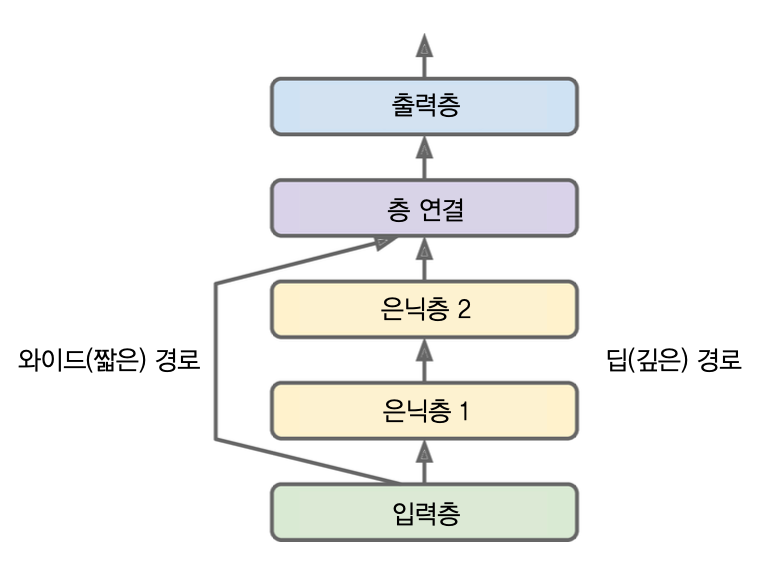

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           930         ['dense_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_6[0][0]']            

In [46]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4659 - val_loss: 0.4313

#### 와이드 & 딥 신경망에서 입력층을 나눠서 함수 API로 구현하기

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

In [48]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

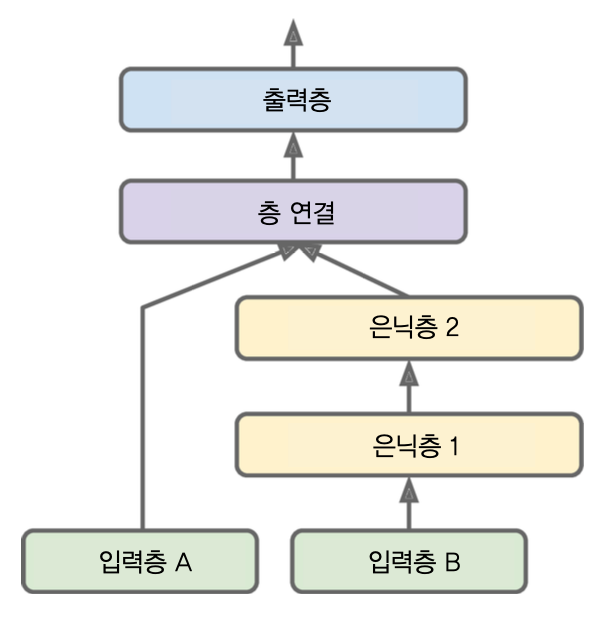

In [49]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

# (X_train_A, X_train_B) 처럼 행렬의 튜플 형식으로 표현

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4644 - val_loss: 0.4315

#### 여러 출력이 필요할 때

다중 작업 분류에 쓰거나, 회귀, 분류의 출력을 함께 낼 때, 또 규제 기법으로 사용한다.

신경망 구조 안에 보조 출력을 추가하여 하위 네트워크가 나머지 네트워크에 의존하지 않고 그 자체로 유용한 것을 학습하는지 확인할 수 있다.

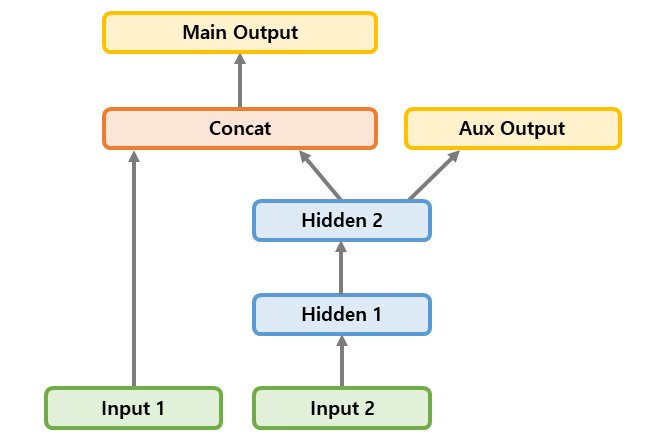

이 모델의 경우, 보조 출력을 통해 deep model만으로 원하는 출력을 얻었는지, deep model과 wide model의 연결을 통해 원하는 출력을 얻었는지 확인할 수 있다. 이를 통해서 과대적합을 감소시키고, 일반화 성능을 높이는 방향으로 규제를 가할 수 있다.

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
# 변경
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [52]:
model.compile(loss=["mse", "mse"], metrics=["accuracy"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
# 손실 가중치를 지정 가능. 케라스는 나열된 손실을 모두 더하여 최종 손실을 구해 훈련에 사용하므로 주 출력의 손실에 더 많은 가중치 부여

In [53]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - main_output_accuracy: 0.0026 - aux_output_accuracy: 9.4746e-04 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117 - val_main_output_accuracy: 0.0044 - val_aux_output_accuracy: 0.0041
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - main_output_accuracy: 0.0028 - aux_output_accuracy: 0.0028 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109 - val_main_output_accuracy: 0.0044 - val_aux_output_accuracy: 0.0044
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - main_output_accuracy: 0.0028 - aux_output_accuracy: 0.0029 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326 - val_main_output_accuracy: 0.004

In [54]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 2ms/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082 - main_output_accuracy: 0.0021 - aux_output_accuracy: 0.0021


ValueError: too many values to unpack (expected 3)

In [55]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 38ms/step


주 출력의 손실과 보조 출력의 손실값은 차이가 있으나, 두 accuracy 값을 비교해 보았을 때 0.0021로 동일하다.  
  => deep model 자체만으로도 우수한 성능을 보인다.

[epoch 300으로 했을 때의 주손실과 보조손실의 결과](https://gooopy.tistory.com/104)

### 10.2.5 서브클래싱 API로 동적 모델 만들기

#### 시퀀셜 API, 함수형 API의 특징
- 모두 선언적이어서 사용할 층과 연결 방식을 먼저 정의하고, 모델에 데이터를 주입하여 훈련이나 추론을 시작할 수 있다.
- 장점
    - 모델 저장, 복사, 공유에 용이
    - 모델 구조를 출력, 분석하기에 좋음
    - 프레임워크가 크기를 짐작하고 타입을 확인하여 에러를 일찍 발견할 수 있음
    - 전체 모델이 층으로 구성된 정적 그래프이므로 디버깅도 쉬움
- 단점
    - 정적임.


반복문, 다양한 크기, 조건문 등의 동적인 구조에 사용하는 명령형 프로그래밍 스타일에는 서브클래싱 API를 사용한다.

In [59]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

함수형과 다르게 input 객체를 생성할 필요 없이, call() 메서드에서 input 매개변수를 사용한다.  
  모델 구조가 call()메서드 안에 숨겨있기 때문에 모델 저장이나 복사를 할 수 없고, summary()를 호출하면 층의 목록만 나열되고, 층 간의 연결 정보를 얻을 수 없다.  
  케라스가 타입과 크기를 미리 확인할 수 없어 실수가 발생하기 쉽다.  
  따라서 높은 유연성이 필요 없다면 앞의 두 방법을 추천한다.

In [61]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

In [63]:
model.summary() # connected to 레이블이 없다

Model: "wide_and_deep_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            multiple                  210       
                                                                 
 dense_17 (Dense)            multiple                  930       
                                                                 
 dense_18 (Dense)            multiple                  36        
                                                                 
 dense_19 (Dense)            multiple                  31        
                                                                 
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


### 10.2.6 모델 저장과 복원

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [66]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4382


In [67]:
model.save("my_keras_model.h5")

In [68]:
model = keras.models.load_model("my_keras_model.h5")

In [69]:
model.predict(X_new)

1/1 [==============================] - 0s 37ms/step


array([[0.5400235],
       [1.650597 ],
       [3.009824 ]], dtype=float32)

In [70]:
model.save_weights("my_keras_weights.ckpt")

In [71]:
model.load_weights("my_keras_weights.ckpt")

### 10.2.7 콜백 사용하기

훈련 도중 일정 간격으로 체크포인트를 저장할 수 있다.

In [87]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [88]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [85]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True) # save_best_only로 최상의 검증 세트 점수에서만 모델 저장
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # 최상의 모델로 롤백
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 857us/step - loss: 0.4382


In [89]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

# 조기 종료 추가, restore_best_weights : 자동으로 최상의 가중치 복원

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4474 - val_lo

363/363 [==============================] - 1s 2ms/step - loss: 0.3361 - val_loss: 0.3321
Epoch 82/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3357 - val_loss: 0.3193
Epoch 83/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3354 - val_loss: 0.3297
Epoch 84/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3349 - val_loss: 0.3709
Epoch 85/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3346 - val_loss: 0.3211
Epoch 86/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3344 - val_loss: 0.3182
Epoch 87/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3340 - val_loss: 0.3577
Epoch 88/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3334 - val_loss: 0.3315
Epoch 89/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3329 - val_loss: 0.3649
Epoch 90/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3330 - val_loss: 

In [81]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [82]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

354/363 [============================>.] - ETA: 0s - loss: 0.3808
val/train: 0.94
363/363 [==============================] - 1s 2ms/step - loss: 0.3828 - val_loss: 0.3586


### 10.2.8 텐서보드를 사용해 시각화하기

In [90]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [91]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2022_09_19-10_58_40'

In [92]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [93]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [94]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4474 - val_loss: 0.4379

In [96]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22324), started 9:46:00 ago. (Use '!kill 22324' to kill it.)

In [97]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2022_09_19-10_59_19'

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [100]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5530 - val_loss: 302.8503
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 11/30
363/363 [==============================

In [101]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data=(np.random.randn(100)+2) * step / 100
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2,32,32,3)
        tf.summary.image("my_images", images * step / 1000, step=step)

## 10.3 신경망 하이퍼파라미터 튜닝하기

In [102]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [103]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [104]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\YOUTH_~1\AppData\Local\Temp/ipykernel_5444/1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [105]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 1s 1ms/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4060 - val_l

363/363 [==============================] - 1s 1ms/step - loss: 0.3384 - val_loss: 0.3424
Epoch 82/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3371 - val_loss: 0.3252
Epoch 83/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3368 - val_loss: 0.3251
Epoch 84/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3362 - val_loss: 0.3991
Epoch 85/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3373 - val_loss: 0.3443
Epoch 86/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3360 - val_loss: 0.3189
Epoch 87/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3356 - val_loss: 0.3264
Epoch 88/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3351 - val_loss: 0.3338
Epoch 89/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3349 - val_loss: 0.3237
Epoch 90/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3344 - val_loss: 

In [106]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 907us/step - loss: 0.3348


In [107]:
y_pred = keras_reg.predict(X_new)

1/1 [==============================] - 0s 28ms/step


In [108]:
np.random.seed(42)
tf.random.set_seed(42)

In [109]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}, 

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
# 파라미터 입력, # random search 탐색 횟수, # cv 검증을 위한 분할 검증 횟수
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8420 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4815 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4519 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4429 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4368 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4340 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4351 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4267 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4258 - val_loss: 0.4040
Epoch 10/100
242/242 [========

Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3678 - val_loss: 0.8462
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3610 - val_loss: 0.8724
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3554 - val_loss: 0.9645
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3525 - val_loss: 0.7225
Epoch 11/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3475 - val_loss: 0.7257
Epoch 12/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3442 - val_loss: 0.7217
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3422 - val_loss: 0.8443
Epoch 14/100
121/121 [==============================] - 0s 875us/step - loss: 0.3650
[CV] END learning_rate=0.005432590230265343, n_hidden=2, n_neurons=94; total time=   6.3s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.0015 - val_loss: 2.9433
Epoch 2/100
2

242/242 [==============================] - 0s 2ms/step - loss: 0.7619 - val_loss: 1.4840
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7266 - val_loss: 1.1083
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7031 - val_loss: 0.8942
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6858 - val_loss: 0.7687
Epoch 11/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6720 - val_loss: 0.6947
Epoch 12/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6602 - val_loss: 0.6524
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6498 - val_loss: 0.6234
Epoch 14/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6401 - val_loss: 0.6061
Epoch 15/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6312 - val_loss: 0.5933
Epoch 16/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6227 - val_loss: 0.

242/242 [==============================] - 0s 2ms/step - loss: 0.4140 - val_loss: 0.4512
Epoch 88/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4132 - val_loss: 0.4481
Epoch 89/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4123 - val_loss: 0.4472
Epoch 90/100
121/121 [==============================] - 0s 825us/step - loss: 0.4209
[CV] END learning_rate=0.00037078874137762145, n_hidden=1, n_neurons=51; total time=  36.5s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 3.4569 - val_loss: 7.5238
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.5656 - val_loss: 8.6120
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 1.0607 - val_loss: 8.4896
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8953 - val_loss: 7.7423
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8236 - val_loss: 6.8202
Epoch 6/100
242/242 [====

242/242 [==============================] - 0s 2ms/step - loss: 0.5219 - val_loss: 0.5045
Epoch 36/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5178 - val_loss: 0.4970
Epoch 37/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5139 - val_loss: 0.4911
Epoch 38/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5101 - val_loss: 0.4887
Epoch 39/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5064 - val_loss: 0.4847
Epoch 40/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5029 - val_loss: 0.4815
Epoch 41/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4994 - val_loss: 0.4776
Epoch 42/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4962 - val_loss: 0.4736
Epoch 43/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4930 - val_loss: 0.4706
Epoch 44/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4901 - val_loss: 

Epoch 14/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4089 - val_loss: 0.3972
Epoch 15/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4029 - val_loss: 0.3852
Epoch 16/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3986 - val_loss: 0.3830
Epoch 17/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3939 - val_loss: 0.3947
Epoch 18/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3900 - val_loss: 0.3713
Epoch 19/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3857 - val_loss: 0.3752
Epoch 20/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3828 - val_loss: 0.3741
Epoch 21/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3803 - val_loss: 0.3782
Epoch 22/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3766 - val_loss: 0.3637
Epoch 23/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3742

Epoch 24/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3735 - val_loss: 0.8587
Epoch 25/100
121/121 [==============================] - 0s 909us/step - loss: 0.3884
[CV] END learning_rate=0.0016535051383872363, n_hidden=2, n_neurons=70; total time=  12.1s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 2.1014 - val_loss: 2.1643
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7146 - val_loss: 0.6141
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6063 - val_loss: 0.5601
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5633 - val_loss: 0.5241
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5302 - val_loss: 0.5017
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5034 - val_loss: 0.4749
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4814 - val_loss: 0.4558
Epoch 8/100
242

242/242 [==============================] - 1s 2ms/step - loss: 1.2328 - val_loss: 307.7495
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9214 - val_loss: 76.3015
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3774 - val_loss: 795.2290
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 34.9847 - val_loss: 704.0446
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3027 - val_loss: 2668.0286
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 9.2431 - val_loss: 1446.2603
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 4.8034 - val_loss: 1540.5355
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 41.9015 - val_loss: 1396.7100
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 10.9509 - val_loss: 1334.0835
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 1.

242/242 [==============================] - 0s 2ms/step - loss: 0.3525 - val_loss: 0.3774
Epoch 19/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3505 - val_loss: 0.3806
Epoch 20/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3479 - val_loss: 0.3420
Epoch 21/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3463 - val_loss: 0.3452
Epoch 22/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3446 - val_loss: 0.3273
Epoch 23/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3425 - val_loss: 0.3279
Epoch 24/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3395 - val_loss: 0.4328
Epoch 25/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3401 - val_loss: 0.3426
Epoch 26/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3366 - val_loss: 0.3228
Epoch 27/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3342 - val_loss: 

Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4391 - val_loss: 0.4107
Epoch 14/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4325 - val_loss: 0.4231
Epoch 15/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4270 - val_loss: 0.4221
Epoch 16/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4221 - val_loss: 0.4084
Epoch 17/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4179 - val_loss: 0.4209
Epoch 18/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4143 - val_loss: 0.4017
Epoch 19/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4106 - val_loss: 0.4322
Epoch 20/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4080 - val_loss: 0.4001
Epoch 21/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4050 - val_loss: 0.4263
Epoch 22/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4027

242/242 [==============================] - 0s 2ms/step - loss: 0.3847 - val_loss: 0.3603
Epoch 33/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3825 - val_loss: 0.4134
Epoch 34/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3819 - val_loss: 0.3633
Epoch 35/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3805 - val_loss: 0.3542
Epoch 36/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3786 - val_loss: 0.3568
Epoch 37/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3783 - val_loss: 0.4216
Epoch 38/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3770 - val_loss: 0.5522
Epoch 39/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3792 - val_loss: 0.5648
Epoch 40/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3763 - val_loss: 0.6416
Epoch 41/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3785 - val_loss: 

Epoch 66/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2583 - val_loss: 0.3732
Epoch 67/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2597 - val_loss: 0.5456
Epoch 68/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2596 - val_loss: 0.3097
Epoch 69/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2579 - val_loss: 0.3561
Epoch 70/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2564 - val_loss: 0.2675
Epoch 71/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2553 - val_loss: 0.3251
Epoch 72/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2548 - val_loss: 0.2719
Epoch 73/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2532 - val_loss: 0.2903
Epoch 74/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2524 - val_loss: 0.2934
Epoch 75/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2524

242/242 [==============================] - 0s 2ms/step - loss: 0.2801 - val_loss: 0.3863
Epoch 50/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2785 - val_loss: 0.2911
Epoch 51/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2770 - val_loss: 0.3429
Epoch 52/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2767 - val_loss: 0.2929
Epoch 53/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2758 - val_loss: 0.2923
Epoch 54/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2756 - val_loss: 0.3031
Epoch 55/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2740 - val_loss: 0.2826
Epoch 56/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2735 - val_loss: 0.3022
Epoch 57/100
121/121 [==============================] - 0s 934us/step - loss: 0.2942
[CV] END learning_rate=0.005803602934201024, n_hidden=3, n_neurons=74; total time=  27.2s
Epoch 1/100
242/242 [=

Epoch 26/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3074 - val_loss: 0.3039
Epoch 27/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3048 - val_loss: 0.4190
Epoch 28/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3083 - val_loss: 0.3422
Epoch 29/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3059 - val_loss: 0.3845
Epoch 30/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3036 - val_loss: 0.3420
Epoch 31/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3007 - val_loss: 0.3019
Epoch 32/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2982 - val_loss: 0.3679
Epoch 33/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2982 - val_loss: 0.3199
Epoch 34/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2943 - val_loss: 0.3334
Epoch 35/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2947

Epoch 40/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3154 - val_loss: 0.3378
Epoch 41/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3188 - val_loss: 0.3145
Epoch 42/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3149 - val_loss: 0.3146
Epoch 43/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3148 - val_loss: 0.3101
Epoch 44/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3112 - val_loss: 0.3410
Epoch 45/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3145 - val_loss: 0.3052
Epoch 46/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3104 - val_loss: 0.3338
Epoch 47/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3089 - val_loss: 0.3331
Epoch 48/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3120 - val_loss: 0.3182
Epoch 49/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3073

242/242 [==============================] - 0s 2ms/step - loss: 0.3484 - val_loss: 0.3990
Epoch 21/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3482 - val_loss: 0.3296
Epoch 22/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3460 - val_loss: 0.3297
Epoch 23/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3435 - val_loss: 0.3287
Epoch 24/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3409 - val_loss: 0.5166
Epoch 25/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3437 - val_loss: 0.8168
Epoch 26/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3424 - val_loss: 0.9087
Epoch 27/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3449 - val_loss: 0.5102
Epoch 28/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3369 - val_loss: 0.6121
Epoch 29/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3371 - val_loss: 

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000219BA90C730>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112...
                                                          0.00502142573

In [110]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [111]:
rnd_search_cv.best_score_

-0.3217036724090576

In [112]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 932us/step - loss: 0.3020


-0.3019881248474121

In [113]:
model = rnd_search_cv.best_estimator_.model
model

In [114]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 944us/step - loss: 0.3020


0.3019881248474121

#### 하이퍼파라미터 최적화 사용 라이브러리

- Hyperopt
- Hyperas, kopt, Talos
- 케라스 튜너
- Scikit-Optimize(skopt)
- Spearmint
- Hyperband
- Sklearn_Deap

### 10.3.1 은닉층 개수


복잡한 문제에서 심층 신경망이 파라미터 효율성이 훨씬 좋다. 복잡한 함수를 모델링하는 데 적은 수의 뉴런을 사용하므로 동일한 양의 훈련 데이터에서 더 높은 성능을 낼 수 있다.

심층 신경망을 활용해서 전이학습을 할 수 있다.

### 10.3.2 은닉층 뉴런 개수

은닉층은 일반적으로 각 층의 뉴런을 점점 줄여 깔때기처럼 구성하나, 대부분의 경우 모든 은닉층에 같은 크기를 사용해도 동일하거나 더 나은 성능을 낸다.

실전에서는 스트레치 팬츠 방식, 즉 필요한 것보다 더 많은 층과 뉴런을 생성하고, 과대적합되지 않도록 조기종료나 규제 기법을 사용하는 것이 효과적이다.

### 10.3.3 학습률, 배치 크기, ETC

#### 학습률

최적의 학습률은 최대 학습률의 절반 정도  

#### 옵티마이저

#### 배치 크기

배치 크기는 모델 성능과 훈련 시간에 큰 영향을 미친다.  
큰 배치 크기의 장점은 하드웨어 가속기를 효율적으로 활용할 수 있어 훈련 알고리즘이 초당 더 많은 샘플을 처리할 수 있다.  
단점은 훈련 초기에 불안정하게 훈련되며, 일반화 성능이 좋지 못할 수 도 있다.

큰 배치 크기는 훈련 시간을 매우 단축시키기 때문에, 학습률 예열을 사용해 시도해보고, 성능이 만족스럽지 못하면 작은 배치 크기로 사용하는 것이 좋다.

#### 활성화 함수

ReLU가 모든 은닉층에 좋은 기본값이며, 출력층의 활성화 함수는 작업에 따라 달라진다.

#### 반복 횟수

반복 횟수는 튜닝하지 않고, 조기 종료를 사용한다.